# A/B Testing Cookie Cats game design

# Introduction

In this notebook I analyze the data from Cookie Cats game A/B test. First I will describe the experiment and overview the data. The I will proceed to reverse engineering the design of experiment. Then finally I will analyze the data and draw conclusions.

## Data Set

This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

## Goal

Does moving the first gate from level 30 to level 40 affect user engagement and retention? Is it better to have it at level 30 or 40?


## Biases

The data has indications of SRM which might introduce bias towards some users.

## Domain knowledge

I am not the designer of the experiment. I have tried Cookie Cats game and it is fun.

## Libraries

In [27]:
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from kagglehub import KaggleDatasetAdapter
from scipy import stats
from scipy.stats import binomtest, kstest, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import (
    proportion_effectsize,
    proportions_chisquare,
    proportions_ztest,
)

## Constants

Here I define constants for the analysis. alpha stands for significance level.

In [2]:
ALPHA = 0.05

## Get Data

In [3]:
raw_df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "mursideyarkin/mobile-games-ab-testing-cookie-cats",
    "cookie_cats.csv",
)
Path("data").mkdir(parents=True, exist_ok=True)
raw_df.to_csv("data/raw_game_design.csv", index=False)

## Data Overview

The data we have is from 90,189 players that installed the game while the AB-test was running.

The variables are:
- userid: A unique number that identifies each player.
- version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
- retention_1: Did the player come back and play 1 day after installing?
- retention_7: Did the player come back and play 7 days after installing?







In [4]:
raw_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Notice the means in experiment group are smaller than contorl group.

In [5]:
raw_df.groupby(by="version").mean()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,4.987564e+06,52.456264,0.448188,0.190201
gate_40,5.009073e+06,51.298776,0.442283,0.182000


Types seems to be correct.

In [6]:
raw_df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

The randomization into control and experiment groups seem approximately equal.

In [7]:
raw_df.groupby(by="version").size()

version
gate_30    44700
gate_40    45489
dtype: int64

Below notice how user-id with 49854 gamerounds has the closest value to it is 2961 which is a lot. I will remove it in processing step as it is not representative of the data.

In [8]:
raw_df["sum_gamerounds"].sort_values(ascending=False).head()

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
Name: sum_gamerounds, dtype: int64

## Data Preprocessing

First I will prepeare the data for analysis by cleaning data. Here I check for null and duplicate userid - it seems there are no such values.

Then I remove user-id with 49854 gamerounds as the closest value to it is 2961. And check that other outliers and leave them in data as theyare grouped approximately equally in both groups.

In [9]:
raw_df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

There is no duplicates in userid.

In [10]:
raw_df["userid"].duplicated().sum()

np.int64(0)

Types seems to be correct.

In [11]:
raw_df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

I will remove user-id with 49854 gamerounds as the closest value to it is 2961.

In [12]:
processed_df = raw_df[raw_df["sum_gamerounds"] != raw_df["sum_gamerounds"].max()]

I took out the big outlier as it is not representative of the data. Below I will check whether remaining outliers after 97.5 quantile are representative of the data. 

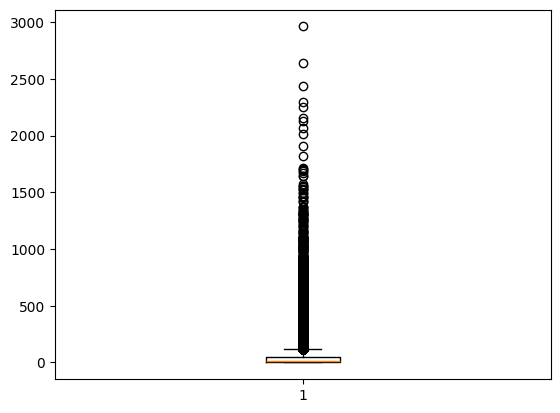

In [13]:
plt.boxplot(processed_df["sum_gamerounds"])
plt.show()

Notice that remaining outliers are grouped approximately equally in both groups. 

In [14]:
all_outliers = processed_df[
    processed_df["sum_gamerounds"] > processed_df["sum_gamerounds"].quantile(0.975)
]
all_outliers.groupby(by="version").size()

version
gate_30    1126
gate_40    1124
dtype: int64

Notice that outliers group has more game_rounds, retention_1 and retention_7. This suggests evidence that highly engaged users play the game more in experiment group.

In [15]:
all_outliers.groupby(by="version").mean()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,4.949197e+06,522.456483,0.945826,0.914742
gate_40,5.171008e+06,532.612100,0.956406,0.921708


Both groups have similar amount of outliers and they are similar to each other thus I will not remove them.

# AB testing

Context
This AB test evaluates whether moving the first in-game gate from level 30 to level 40 affects user engagement and retention. Players were randomly assigned to either version upon installation, and data was collected over 14 days.

## Design of experiment:

As the experiment was not designed by me and is based on pre-existing Kaggle data, I will be making some assumptions in design:

- Subject of experiment is user-id's
- In analysis part of project I will check whether its distribution to both groups is approximately equal to ensure randomization was successful. (My invariant metric is count of user-id's)
- My evaluation metrics will be retention_1, retention_7 and sum_gamerounds. Notice retention metrics have binomial distribution while we dont know for sure what distribution is sum_gamerounds as its type is integer.
- When designing the experimetn it is important to decide on duration of experiment, and the amount of flow used for experiment. In description of data I find that duration of experiment is 14 days or more while I cannot say anything of how of the flow was used but this is unimportant for our goal.


- As I did not design the experiment in cells below I reverse engineer with which metrics experiment has ennough power:
    - practical significance = 0.01 and 2 for game rounds
    - statistical significance = 0.05
    - statistical power = 0.8

### Power analysis

Comparing this with Evan's Miller calculator I get 38845 and 24322 which is similar to my more conservative using cohen's h. While for game rounds I get 1135 using simulation. The statistics used:
- practical significance = 0.01 and 2 for game rounds
- statistical significance = 0.05
- statistical power = 0.8

While our total sample size is 90188 as seen below thus I have enought power to detect effect size of 2 for game rounds and 0.01 for retention 1 and 7.

In [16]:
processed_df.groupby(by=["version", "retention_1"]).size()

version  retention_1
gate_30  False          24665
         True           20034
gate_40  False          25370
         True           20119
dtype: int64

In [17]:
control_retention_1_ratio = (
    processed_df.groupby(by=["version", "retention_1"]).size().iloc[1]
    / processed_df.groupby(by=["version", "retention_1"]).size().iloc[0:2].sum()
)
control_retention_7_ratio = (
    processed_df.groupby(by=["version", "retention_7"]).size().iloc[1]
    / processed_df.groupby(by=["version", "retention_7"]).size().iloc[0:2].sum()
)
control_rounds = processed_df[processed_df["version"] == "gate_30"]["sum_gamerounds"]

In [18]:
def required_sample_size(p_baseline, min_effect, power=0.8, alpha=0.05):
    p_alt = p_baseline + min_effect
    effect_size = proportion_effectsize(p_baseline, p_alt)  # Cohen's h
    analysis = NormalIndPower()
    sample_size = analysis.solve_power(
        effect_size=effect_size, power=power, alpha=alpha, ratio=1.0, alternative="two-sided"
    )
    return round(sample_size)

In [19]:
required_sample_size(control_retention_1_ratio, min_effect=0.01, power=0.8, alpha=ALPHA)

38899

In [22]:
required_sample_size(control_retention_7_ratio, min_effect=0.01, power=0.8, alpha=ALPHA)

24655

In [23]:
def required_sample_size_simulation(data, min_effect, power= 0.8, alpha= 0.05):
    n = 100
    max_n = 100000

    while n < max_n:
        power_achieved = 0

        for _ in range(1000):
            control = np.random.choice(data, size=n, replace=True)
            treatment = np.random.choice(data, size=n, replace=True) + min_effect
            _, p_value = stats.mannwhitneyu(control, treatment)

            if p_value < alpha:
                power_achieved += 1

        empirical_power = power_achieved / 1000

        if empirical_power >= power:
            return n

        n = int(n * 1.5)

    return max_n

In [24]:
required_sample_size_simulation(control_rounds, min_effect=2, power=0.8, alpha=ALPHA)

1135

In [19]:
processed_df.count()[0]

/tmp/ipykernel_85158/708003975.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  processed_df.count()[0]


np.int64(90188)

## Analysing experiment:

Things I will do in this section:
- Check whether control and experiment groups are comparable which means that the randomization was done properly and thus no biases are introduced.
- Decide on the test depending on sample size, whether standard error is known, distribution assumptions.
- Do the test, check whether it is significant. (i.e. confidence intervals are not within each other, or whether 0 is not inside effect size ci)
- Some robustness checks which is use different test to test the same metric.
- Decide on how many metrics, and how significance level is adjusted by that to take care of false positives.
- Decide whether to recommend, reject or test for more.

### Check randomization

In cells below I show that the randomization was not done properly and there is a bias in the experiment 

First I check whether control and experiment groups are comparable by testing. The data is captured when a new user installs and then they are randomly assigned to control or experiment group. In perfect world the split should be 50% for both groups.

- **Null hypothesis**: Numer of users are approximately split 50% for both groups
- **Alternative hypothesis**: Number of users are not split 50% for both groups

After performing binomial test I get p-value of 0.0086 which is statistically significant at 95% confidence level. This means that the split is not random and there is a bias in the experiment.

Next I will take out users who have 0 game rounds as that might be a reason for bias.

In [33]:
def check_randomization(nobs):
    total_control = nobs[0]
    total = sum(nobs)

    # Perform binomial test
    result = binomtest(total_control, total, p=0.5)

    # Calculate z-score
    p_control = total_control / total
    z_score = (p_control - 0.5) / (0.5 * (1 - 0.5) / total) ** 0.5
    return z_score, result.pvalue

In [34]:
total_control = processed_df.groupby(by="version").size().iloc[0]
total_experiment = processed_df.groupby(by="version").size().iloc[1]
z_score, p_value = check_randomization(nobs=[total_control, total_experiment])
print(f"z-score: {z_score:.3f}")
print(f"p-value: {p_value:.4f}")

z-score: -2.631
p-value: 0.0086


I believe randomization process can go wrong and found that if game_rounds played is 0 then user-id might not be assigned properly. As this might mean that users have installed the game but haven't started playing and depending on when user-id is given this might disrupt analysis. Although it is hard to say as I am not the designer of experiment.

I will investigate this further by taking out users who have 0 game rounds out of the test

In [21]:
processed_df.groupby(by="version").size()


version
gate_30    44699
gate_40    45489
dtype: int64

In [22]:
processed_df[processed_df["sum_gamerounds"]!=0].groupby(by="version").size()

version
gate_30    42762
gate_40    43432
dtype: int64

- **Null hypothesis**: Numer of users are approximately split 50% for both groups without 0 game rounds users
- **Alternative hypothesis**: Number of users are not split 50% for both groups without 0 game rounds users

After performing binomial test I get p-value of 0.0227 which is not statistically significant at 95% confidence level. This means I reject Null hypothesis.


In [35]:
total_control_no_0_gr = (
    processed_df[processed_df["sum_gamerounds"] != 0].groupby(by="version").size().iloc[0]
)
total_experiment_no_0_gr = (
    processed_df[processed_df["sum_gamerounds"] != 0].groupby(by="version").size().iloc[1]
)
z_score, p_value = check_randomization(nobs=[total_control_no_0_gr, total_experiment_no_0_gr])
print(f"z-score: {z_score:.3f}")
print(f"p-value: {p_value:.4f}")

z-score: -2.282
p-value: 0.0227


Even if I take out such users who have 0 game rounds the data still shows statistical difference between control and experiment.

This disrepency might be a symptom of a bug in the way units were randomized. This is known as simple ratio mismatch (SRM). In [article](https://www.microsoft.com/en-us/research/articles/diagnosing-sample-ratio-mismatch-in-a-b-testing/) by Microsoft shows many reasons for SRM and way it can disrupt the analysis.

Some implications of SRM:
- Results could be compromised as certain user segments might be over/under-represented in one group.
- Any conclusions drawn from the test may be invalid

It would be a good idea to check the way it might be disrupting analysis, and ways we can improve our data collection to treat SRM. But as we only have the data, and can't investigate the process how the data is being collected I will proceed with analysis noting the imbalance and the bias it might bring.

**Important disclaimer**: gate 30 and gate 40 are not statistically randomly split. Which might be influencing the results as this might be indication of SRM. Although p-value of such a split occuring is 0.86%. When conditioning on users without any game rounds p-values is 2.2% percent which indicates there might be a bug when assigning new user-id's. Although both of p-values are not too low, as in microsoft article is suggested to flag for SRM in conservative manner with p-value of 0.0005 to avoid false positives

### Decide on test

- t-test for continious variables when sample size is small or when variance is not known
- z-test for continious variables when sample size is large and variance is known from previous studies
- chi-squared test for comparing categorical variables
- binomial test only for one group, like checking whther randomization was done properly
- U-test for alternative to t-test when data has non-normal distribution.
- bootstrap groups and compare their difference confidence interval with practical significance

For retention_1 and retention_2 I will use z-test for proportions and use chi-squared test for additional test for robustness.

For average game rounds I will use u-test as it does not have normal distribution and aditionally bootstrap to check robustness.

### Test using evaluation metrics

#### Retention after 1 day

- **Null hypothesis**: retention_1 is the same in both groups
- **Alternative hypothesis**: retention_1 is different in both groups

In below cells I show how retention_1 z-test p-value is above 0.05 thus I fail to reject Null hypothesis

Below is code to ready data for tests

In [36]:
control_successes_retention_1 = processed_df.groupby(by=["version", "retention_1"]).size().iloc[1]
control_trials_retention_1 = processed_df.groupby(by=["version", "retention_1"]
                                                  ).size().iloc[0:2].sum()
exp_successes_retention_1 = processed_df.groupby(by=["version", "retention_1"]).size().iloc[3]
exp_trials_retention_1 = processed_df.groupby(by=["version", "retention_1"]).size().iloc[2:4].sum()
count = [control_successes_retention_1, exp_successes_retention_1]
nobs = [control_trials_retention_1, exp_trials_retention_1]

Notice how retention_1 z-test p-value is above 0.05 thus I fail to reject Null hypothesis.

In [28]:
stat, retention_1_p_ztest = proportions_ztest(count, nobs)
print("z-value: ", stat)
print("p-value: ", retention_1_p_ztest)

z-value:  1.787103509763628
p-value:  0.0739207603418346


The confidence interval includes 0 thus we fail to reject Null hypothesis.

In [29]:
treatment_effect = count[1] / nobs[1] - count[0] / nobs[0]

p_pooled = (count[0] + count[1]) / (nobs[0] + nobs[1])
se_diff = np.sqrt(p_pooled * (1 - p_pooled) * (1 / nobs[0] + 1 / nobs[1]))
ci = (
    treatment_effect - stats.norm.ppf(1 - ALPHA / 2) * se_diff,
    treatment_effect + stats.norm.ppf(1 - ALPHA / 2) * se_diff,
)
print("CI: ", ci)

CI:  (np.float64(-0.01240255012236162), np.float64(0.0005721569482933083))


Test for robustness also shows that we fail to reject Null hypothesis as p-value is above 0.05.

In [30]:
chi2_stat, retention_1_p_chi2, _ = proportions_chisquare(count, nobs)
print("chi-value: ", chi2_stat)
print("p-value for one-side: ", retention_1_p_chi2)


chi-value:  3.19373895460949
p-value for one-side:  0.07392076034183397


#### Retention after 7 days

- **Null hypothesis**: retention_7 is the same in both groups
- **Alternative hypothesis**: retention_7 is different in both groups

In below cells I show how retention_7 z-test p-value is below 0.05 thus I reject Null hypothesis. With confidence interval I show the effect direction is better when asigning user-id's to gate 30

Below is code to ready data for tests

In [37]:
count = [
    processed_df.groupby(by=["version", "retention_7"]).size().iloc[1],
    processed_df.groupby(by=["version", "retention_7"]).size().iloc[3],
]
nobs = [
    processed_df.groupby(by=["version", "retention_7"]).size().iloc[0:2].sum(),
    processed_df.groupby(by=["version", "retention_7"]).size().iloc[2:4].sum(),
]

Notice how retention_7 z-test p-value is above 0.05 thus I can reject Null hypothesis.

In [38]:

stat, retention_7_p = proportions_ztest(count, nobs)
print("z-value: ", stat)
print("p-value: ", retention_7_p)

z-value:  3.1574100858819936
p-value:  0.0015917731773993442


Confidence interval does not include 0 thus I reject Null hypothesis. Although notice the direction of the effect is opposite to what I expected. As that is less users coming back after 7 days in experiment group than control group.

In [39]:
treatment_effect = count[1] / nobs[1] - count[0] / nobs[0]

p_pooled = (count[0] + count[1]) / (nobs[0] + nobs[1])
se_diff = np.sqrt(p_pooled * (1 - p_pooled) * (1 / nobs[0] + 1 / nobs[1]))
ci = (
    treatment_effect - stats.norm.ppf(1 - ALPHA / 2) * se_diff,
    treatment_effect + stats.norm.ppf(1 - ALPHA / 2) * se_diff,
)
print("Treatment effect: ", treatment_effect)
print("CI: ", ci)

Treatment effect:  -0.00818318160884296
CI:  (np.float64(-0.013262895930399789), np.float64(-0.003103467287286132))


Robustness check shows that I can reject Null hypothesis as p-value is below 0.05.

In [40]:
chi2_stat, pval, _ = proportions_chisquare(count, nobs)
print("chi-value: ", chi2_stat)
print("p-value: ", pval)

chi-value:  9.96923845042939
p-value:  0.0015917731773992998


#### Average of game rounds

- **Null hypothesis**: average game rounds is the same in both groups
- **Alternative hypothesis**: average game rounds is different in both groups

In cells below I fail to reject Null hypothesis using U-test and bootstrap.

##### Assumptions

- **Null hypothesis**: data is normal distributed
- **Alternative hypothesis**: data is not normal distributed

I show that data is not normal distributed using kolmogorov-smirnov test. As can be seen below p-value is below 0.05 thus data is not normal distributed.

I take a look at visual representation of normality which does not look normal as the data is right skewed.

In [35]:
control_rounds = processed_df[processed_df["version"] == "gate_30"]["sum_gamerounds"]
test_rounds = processed_df[processed_df["version"] == "gate_40"]["sum_gamerounds"]

stat, pval = kstest(control_rounds, test_rounds)
print("Kolmogorov-Smirnov test statistic:", stat)
print("p-value for normality:", pval)

Kolmogorov-Smirnov test statistic: 0.010258010418840668
p-value for normality: 0.01727609923280408


For robustness I will look at visual representation of normality which does not look normal as the data is right skewed.

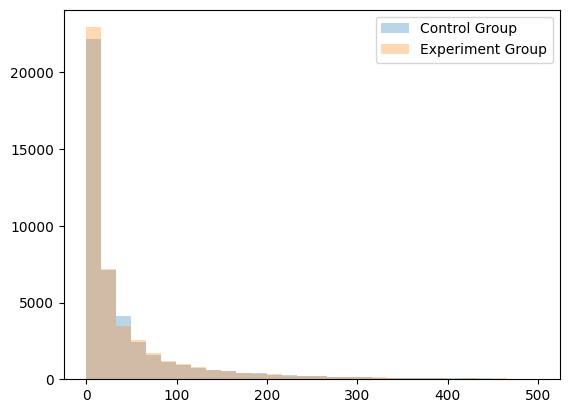

In [36]:
cont_removed_outliers = control_rounds[control_rounds < 500]  # noqa: PLR2004
exp_removed_outliers = test_rounds[test_rounds < 500]  # noqa: PLR2004
plt.hist(cont_removed_outliers, bins=30, alpha=0.3, label="Control Group")
plt.hist(exp_removed_outliers, bins=30, alpha=0.3, label="Experiment Group")
plt.legend()
plt.show()

##### U-test average game rounds

 As data is not normal distributed I will do U-test which does not take normality distirbution into assumptions. Below shows that the difference is almost significant, suggesting a borderline difference in distributions. This suggests that more testing is necesserary to make decision.

In [37]:
stat, p_u_test = mannwhitneyu(control_rounds, test_rounds)
print(f"Mann-Whitney U test p-value: {p_u_test}")

Mann-Whitney U test p-value: 0.05089155279145376


##### Bootstrap

As u-test is borderline significant, I will do bootstrap to check robustness. First, I will do bootstrap and then directly calculate confidence intervals both analytically and empirically.

After calculations I found that bootstrap fail to reject Null hypothesis.

In [38]:
import numpy as np

n_bootstraps = 10000
bootstrap_means_control = np.array(
    [
        np.mean(np.random.choice(control_rounds, size=len(control_rounds), replace=True))
        for _ in range(n_bootstraps)
    ]
)
bootstrap_means_test = np.array(
    [
        np.mean(np.random.choice(test_rounds, size=len(test_rounds), replace=True))
        for _ in range(n_bootstraps)
    ]
)

I will take a look at bootstrap distributions which seem similar from below. Notice the data now is normaly distirbuted with similar variances only experiment group is slightly more to the left.

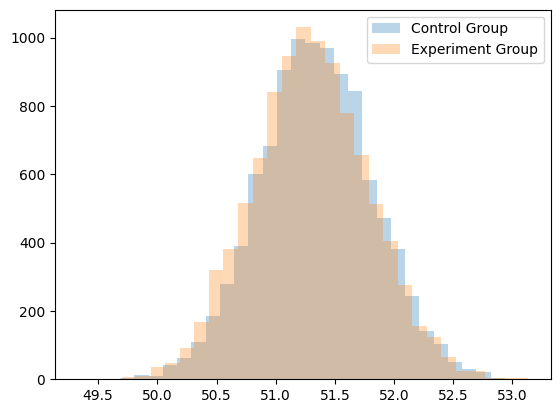

In [39]:
plt.hist(bootstrap_means_control, bins=30, alpha=0.3, label="Control Group")
plt.hist(bootstrap_means_test, bins=30, alpha=0.3, label="Experiment Group")
plt.legend()
plt.show()

Below confidence interval is calcualted in 2 ways. Empirical and analytical way as per requirements. Notice from empirical way 0 is inside the confidence interval thus I fail to reject Null hypothesis.

In [40]:
# Empirical way
differences = bootstrap_means_test - bootstrap_means_control
ci_lower_emp = np.percentile(differences, 2.5)  # 2.5th percentile
ci_upper_emp = np.percentile(differences, 97.5)  # 97.5th percentile

print("Treatment effect:", differences.mean())
print("95% CI (empirical):", (ci_lower_emp, ci_upper_emp))

Treatment effect: -0.0500458446099369
95% CI (empirical): (np.float64(-1.3903328144500615), np.float64(1.2628709526190065))


Similarly from analytical way 0 is inside the confidence interval thus I fail to reject Null hypothesis.

In [41]:
# Analytical way
treatment_effect = np.mean(bootstrap_means_test) - np.mean(bootstrap_means_control)
se = np.sqrt(np.var(bootstrap_means_test) + np.var(bootstrap_means_control))
z = stats.norm.ppf(1 - ALPHA / 2)
ci_lower = treatment_effect - z * se
ci_upper = treatment_effect + z * se
z_score = treatment_effect / se
game_rounds_p = 2 * (1 - stats.norm.cdf(abs(z_score)))

print("Treatment effect:", treatment_effect)
print("95% CI (parametric):", (ci_lower, ci_upper))
print("Bootstrap p-value (normal approximation):", game_rounds_p)


Treatment effect: -0.050045844609933
95% CI (parametric): (np.float64(-1.389247440641312), np.float64(1.289155751421446))
Bootstrap p-value (normal approximation): 0.9416122081796972


I care more about the central tendency rather than underlying distribution, so the bootstrap results is a bit more relevant. Thus I fail to reject Null hypothesis.

## Adjust p-values

When using multiple tests it is important to take into account false positive that might occur thus I adjust p-values of my test for my final decision and find that only one of my tests is significant.
- Retention_1 - z-test for proportions
- Retention_7 - z-test for proportions
- Average game rounds - U-test

In [42]:
p_values = [retention_1_p_ztest, retention_7_p, p_u_test]
test_names = ["Retention 1", "Retention 7", "Avg Game Rounds"]

reject, p_adjusted, _, _ = multipletests(p_values, alpha=ALPHA, method="fdr_bh")

print("Multiple Test Correction (Benjamini-Hochberg FDR):")
print("-" * 60)
print(f"{'Test':<15} {'Original p':<12} {'Adjusted p':<12} {'Significant?':<15}")
print("-" * 60)
for test, p_orig, p_adj, sig in zip(test_names, p_values, p_adjusted, reject, strict=True):
    print(f"{test:<15} {p_orig:.4f}       {p_adj:.4f}       {'Yes' if sig else 'No':<15}")

Multiple Test Correction (Benjamini-Hochberg FDR):
------------------------------------------------------------
Test            Original p   Adjusted p   Significant?   
------------------------------------------------------------
Retention 1     0.0739       0.0739       No             
Retention 7     0.0016       0.0048       Yes            
Avg Game Rounds 0.0509       0.0739       No             


Notice only one of our tests is significant which is retention_7. But Notice that the direction of the effect is opposite to what I expected. As that is less users coming back after 7 days in experiment group than control group

# Conclusions

**Goal**: Does moving the first gate from level 30 to level 40 affect user engagement and retention? Is it better to have it at level 30 or 40?

**Answer**: Moving first gate to level 40 gets less users coming back after 7 days. My recommendation is to stay with gate 30.

I have tested whether gate 40 has more users coming back and more engaged users than gate 30 using following metrics:
- how many users come back after 1 day
- how many users come back after 7 days
- average game rounds played by user

After analysing the data I found that only one of our tests is significant which is retention after 7 days. The direction of the effect is that there is less users coming back after 7 days in gate 40 than gate 30. 

**Important disclaimer**: gate 30 and gate 40 are not statistically randomly split which might introduce bias in the results. But as p-values are not too low to discredit all of the anlaysis, I will not recommend investigating randomization process due to time constraints. 

# Improvements

- investigate randomization process to see if there is a bug in the way user-id's are assigned.
